1. 데이터 불러오기/변환
2. Overview
  + [ ] 수집 체널 List
3. 당월자료 Summary : Graph
  + [ ] 유형별 수집자료 : 수치, 비율, 전월대비 증/감율
  + [x] Trend
  + [x] 비율
  + [ ] Wordcloud(A/B/C) : color 설정
  + [ ] 연관단어(keyword 기준)
3. 이메일 양식 작성

In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# from konlpy.tag import Okt
# okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 분석1 : Trend 탐식 시, 이상치 확인
from sklearn.neighbors import LocalOutlierFactor

# 분석2 : wordcloud 준비
from wordcloud import WordCloud

# 분석3 : text rank 도출
import itertools
import nltk

# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta

# 내용공유(e-mail, 회사) 
import send_email as se
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [5]:
# 제품군 정보
category_group = '셀렉스'
category_en = 'selex'
category = [['코어프로틴분말', '비리다'],
            ['코어프로틴분말', '냄새'],
            ['코어프로틴분말', '맛없다'],
            ['코어프로틴분말', '녹다'],
            ['밀크세라마이드', '달다'],
            ['밀크세라마이드', '비싸다'],
            ['밀크세라마이드', '비리다'],
            ['밀크세라마이드', '효과'],
            ['밀크세라마이드', '맛없다'],
            ['밀크세라마이드', '뭉치다'],
            ['슬림25', '녹다'],
            ['슬림25', '안 녹다'],
            ['코어프로틴바', '식감'],
            ['코어프로틴바', '딱딱'],
            ['스포츠RTD', '냄새'],
            ['스포츠RTD', '향']]


In [88]:
category_group = '백색시유'
category_en = 'sangha'
category = [['상하 우유',  '비리다'],
            ['상하 우유',  '냄새'  ],
            ['상하 우유',  '맛없다'],
            ['상하 우유',  '녹다'  ],
            ['아이스크림', '녹다'  ],
            ['아이스크림', '달다'  ],
            ['아이스크림', '파손'  ] ]


In [89]:
category_group = '아몬드브리즈'
category_en = 'almond'
category = [['아몬드브리즈', '비리다'],
            ['아몬드브리즈', '냄새'  ],
            ['아몬드브리즈', '맛없다'],
            ['아몬드브리즈', '밍밍']
           ]


In [12]:
category_group = '두유'
category_en = 'soymilk'
category = [['두유', '비리다'],
            ['두유', '냄새'  ], 
            ['두유', '맛없다'],
            ['두유', '밍밍'  ],
            ['두유', '달다'  ]
           ]


In [126]:
category_group

'상하목장'

### I.데이터 불러오기

In [6]:
# 제품군 정보
df_product = pd.read_excel('./PRODUCT.xlsx','Sheet1')
df_product['PRODUCT_CODE'] = df_product['PRODUCT_CODE'].astype(object)
df_product = df_product[df_product['category1'] == category_group ]

In [7]:
query_values = tuple(df_product.PRODUCT_CODE.to_list())
query_values = str(query_values)

In [ ]:
# query_values

In [9]:
#########
# rawdata 불러오기
###

# DB연결
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')

# cursor 설정
cursor = conn.cursor(pymysql.cursors.DictCursor)


In [13]:
# 쿼리실행: 전체리뷰
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집채널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2,3,4,5)
        and PRODUCT_CODE in ''' + query_values + '''and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between LAST_DAY(NOW() - interval 1 month) + interval 1 DAY and DATE_ADD(curdate(),INTERVAL -1 day)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT desc
        '''
cursor.execute(sql)
df_review_all = cursor.fetchall()
df_review_all = pd.DataFrame(df_review_all)
df_review_all['리뷰등록일'] = pd.to_datetime(df_review_all['리뷰등록일'])
df_review_all = df_review_all.join(df_product.set_index('상품명')['category2'], on='상품명')

df_review_all = df_review_all[df_review_all.columns[2:]].drop_duplicates().reset_index(drop=True)

df_review_all['리뷰등록일'] = df_review_all['리뷰등록일'].dt.strftime('%m/%d')

df_review_all = df_review_all.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')


In [14]:
df_review_all.head()

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2
0,5,식단 조절때문에 늘 구비해 놓는 제품입니다\n배송 빨라서 좋아요,08/30,3 네이버,스포츠RTD
1,5,아침에 하나씩 든든히 먹고있어요\n두유하고는 느낌이 달라서 처음에는\n좀 어색했는데...,08/30,3 네이버,스포츠RTD
2,4,배송이 빨라요~\n항상 먹던거라 맛 좋네요,08/30,3 네이버,스포츠RTD
3,5,너무 좋아요~ 다음에 또 구매할게요^^,08/30,3 네이버,스포츠RTD
4,5,부담 없이 아침이나 간식으로 먹기 좋아요,08/30,3 네이버,스포츠RTD


In [15]:
# if category_group == '상하목장':
#     df_review_2 = pd.read_excel('./kurly_review.xlsx','Sheet1')
#     df_review_2 = df_review_2[['구매자평점', '리뷰상세내용', '리뷰등록일', '수집채널', 'category2']]
#     df_review_2['리뷰등록일'] = pd.to_datetime(df_review_2['리뷰등록일'])
#     df_review_2['리뷰등록일'] = df_review_2['리뷰등록일'].dt.strftime('%m/%d')
#     df_review_2['구매자평점'] = df_review_2['구매자평점'].astype('int')

#     df_review_all= pd.concat([df_review_all,df_review_2],axis=0, ignore_index=True)
#     df_review_all['구매자평점'] = df_review_all['구매자평점'].apply(str)
# else:
#     pass

In [16]:
if category_group == '두유':
    df_review_all2 = pd.read_excel('./kakaomakers.xlsx', 0)
    df_review_all2 = df_review_all2[(df_review_all2['GUBUN'] =='제품후기')]
    df_review_all2 = df_review_all2[(df_review_all2['category1'] == category_group) ].reset_index()
    df_review_all2 = df_review_all2[['구매자평점', '리뷰상세내용', '리뷰등록일', '수집채널', 'category2']]
    df_review_all2['리뷰등록일'] = pd.to_datetime(df_review_all2['리뷰등록일'])
    df_review_all2['리뷰등록일'] = df_review_all2['리뷰등록일'].dt.strftime('%m/%d')
    df_review_all2['구매자평점'] = df_review_all2['구매자평점'].astype('int')
else:
    pass

In [109]:
# df_review_all.groupby('문의내용').count()

In [110]:
df_review_all2

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2
0,4,캔으로된제품을 재구매해서 먹는중인데.\n아주 만족입니다.\n하지만 한가지 아쉬운점은...,08/26,카카오메이커스,프로바이오틱스
1,4,오! 받자마자 우선 너무 귀엽다! 소리가 나왔어요 ㅎㅎ30알이 정말 다 들었나 싶은...,07/30,카카오메이커스,프로바이오틱스
2,4,첫인상이 너무 귀여워요 🤭 ㅋㅋㅋㅋㅋ 챙겨먹어야지 하고 사뒀다 안먹고 버린 영양제가...,08/01,카카오메이커스,프로바이오틱스
3,4,가루로된 유산균이 장까지 도달하기 어렵다고해서 캡슐로 된 제품이라 구입했어요. 매일...,07/31,카카오메이커스,프로바이오틱스
4,4,셀렉스라 믿고 구매했습니다. \n화장실을 잘 못가서 언제나 유산균을 섭취하고 있었는...,08/11,카카오메이커스,프로바이오틱스
...,...,...,...,...,...
147,4,배송을 잘 받았네요,07/31,카카오메이커스,프로바이오틱스
148,4,빠른배송 감사합니다,07/31,카카오메이커스,프로바이오틱스
149,4,배송도 빠르고 면역력도 좋았음 좋겠어요,07/31,카카오메이커스,프로바이오틱스
150,4,좋아요. 감사합니다,07/31,카카오메이커스,프로바이오틱스


In [17]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')
twitter.add_dictionary('의향', 'Noun')


def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1

In [18]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all['token'] = df_temp1
df_review_all['token_attribution'] = token_all


In [19]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all2['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all2['token'] = df_temp1
df_review_all2['token_attribution'] = token_all


In [20]:
df_review_all.head(2)

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token,token_attribution
0,5,식단 조절때문에 늘 구비해 놓는 제품입니다\n배송 빨라서 좋아요,08/30,3 네이버,스포츠RTD,식단 조절 때문 에 늘 구비 해 놓다 제품 이다 배송 빨 라서 좋다,"[식단/Noun, 조절/Noun, 때문/Noun, 에/Josa, 늘/Noun, 구비..."
1,5,아침에 하나씩 든든히 먹고있어요\n두유하고는 느낌이 달라서 처음에는\n좀 어색했는데...,08/30,3 네이버,스포츠RTD,아침 에 하나 씩 든든하다 먹다 어요 두유 하고는 느낌 이 달라 서 처음 에는 좀 ...,"[아침/Noun, 에/Josa, 하나/Noun, 씩/Adverb, 든든하다/Adje..."


In [21]:
df_review_all2.head(2)

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token,token_attribution
0,4,종이 빨대가 생각보다 튼튼해요\n두유와 달리 가라앉아 쌓이는 고형물 없이 액체 느낌...,08/29,카카오메이커스,어메이징 오트,종이 빨대 가 생각 보다 튼튼하다 두유 와 달리 가라 앉다 쌓이다 고형 물 없이 액...,"[종이/Noun, 빨대/Noun, 가/Josa, 생각/Noun, 보다/Josa, 튼..."
1,4,기존 아몬드브리즈 항상먹다가\n시켜봤는데 완전 맛있어요\n아몬드보다 더 부드럽고 향...,08/29,카카오메이커스,어메이징 오트,기존 아몬드브리즈 항상 먹다 다가 시키다 보다 완전 맛있다 어요 아몬드 보다 더 부...,"[기존/Noun, 아몬드브리즈/Noun, 항상/Noun, 먹다/Verb, 다가/No..."


In [22]:
###############
# 데이터 유형 분류
#####
# 부정 리뷰
df_review_neg= df_review_all[(df_review_all['구매자평점']=='1')|(df_review_all['구매자평점']=='2')]

# 긍정 리뷰
df_review_pos= df_review_all[(df_review_all['구매자평점']=='4')|(df_review_all['구매자평점']=='5')]

# 중립 리뷰
df_review_nue= df_review_all[(df_review_all['구매자평점']=='3')]


In [68]:
# print('<<기간 내 리뷰수>>' )
# print(' - 긍정(54   ) : {:,.0f}'.format(len(df_review_pos)) )
# print(' - 중립(  3  ) : {:,.0f}'.format(len(df_review_nue)) )
# print(' - 부정(   21) : {:,.0f}'.format(len(df_review_neg)) )

In [69]:
# print('<<기간 내 리뷰수 비중>>' )
# print(' - 긍정(54   ) : {:,.1f}%'.format(len(df_review_pos)/len(df_review_all)*100 ) )
# print(' - 중립(  3  ) : {:,.1f}%'.format(len(df_review_nue)/len(df_review_all)*100 ) )
# print(' - 부정(   21) : {:,.1f}%'.format(len(df_review_neg)/len(df_review_all)*100 ) )

In [25]:
# print('<<기간 내 리뷰 증감률>>' )
# print(' - 전체(54321) : {:,.1f}%'.format( (len(df_review_all)-len(df_review_all_before))/len(df_review_all_before)*100 ) )
# print(' - 긍정(54   ) : {:,.1f}%'.format( (len(df_review_pos)-len(df_review_pos_before))/len(df_review_pos_before)*100 ) )
# print(' - 중립(  3  ) : {:,.1f}%'.format( (len(df_review_nue)-len(df_review_nue_before))/len(df_review_nue_before)*100 ) )
# print(' - 부정(   21) : {:,.1f}%'.format( (len(df_review_neg)-len(df_review_neg_before))/len(df_review_neg_before)*100 ) )

In [26]:
# df_review_neg.head(2)

### III.데이터 리포팅

In [23]:
###############
# 리포트용 자료 만들기 : 1.제품 현황
#####

#당월 날짜 생성
start = (datetime.today().replace(day=1)).strftime('%Y/%m/%d')
end = ((datetime.today()+relativedelta(months=1)).replace(day=1)-timedelta(days=1)).strftime('%Y/%m/%d')

monthly_date = [d.strftime('%m/%d') for d in pd.date_range(start, end, freq='D')]



In [114]:
# REPORT.head()

In [24]:
trend_review_all = pd.pivot_table(df_review_all, index = '리뷰등록일', values = '리뷰상세내용', columns = '구매자평점', aggfunc = 'count').fillna(0)

trend_review_pos = pd.pivot_table(df_review_pos, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_nue = pd.pivot_table(df_review_nue, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_neg = pd.pivot_table(df_review_neg, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_new = pd.pivot_table(df_review_all2,index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)


REPORT = pd.DataFrame()
REPORT['리뷰등록일'] = monthly_date
REPORT_01 = pd.merge(REPORT, trend_review_pos, left_on=['리뷰등록일'], right_on=trend_review_pos.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '긍정리뷰' }, inplace = True)

REPORT_01 = pd.merge(REPORT_01, trend_review_nue, left_on=['리뷰등록일'], right_on=trend_review_nue.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '중립리뷰' }, inplace = True)

REPORT_01 = pd.merge(REPORT_01, trend_review_neg, left_on=['리뷰등록일'], right_on=trend_review_neg.index, how='outer')
REPORT_01.rename(columns = { '리뷰상세내용' : '부정리뷰' }, inplace = True)
# REPORT_01 = REPORT_01.fillna('')

REPORT_01 = pd.merge(REPORT_01, trend_review_new, left_on=['리뷰등록일'], right_on=trend_review_new.index, how ='left')
REPORT_01.rename(columns = { '리뷰상세내용' : '신규체널' }, inplace = True)

REPORT_01['리뷰등록일'] = REPORT_01['리뷰등록일'].str.slice(start=-5)
REPORT_01['리뷰등록일'] = REPORT_01['리뷰등록일'].str.replace('-', '/')


In [25]:

# word cloud 생성 모듈
def wordcloud_gen(dataset, color):
    text = dataset.to_list()
    text_all = listToString(text)
    wc1 = WordCloud(font_path= path, stopwords = stopword, width = 600, height = 600, background_color="white", repeat=True, colormap = color)
    return wc1.generate(text_all)


stopword = ['먹다', '하다', '좋다'  , '예요', '이에요', '있다', '맛있다', '같다', '없다', '보통', '최고', '주문', '보다', '매일',
         '구매', '에서', '먹이다', '않다', '자다'  , '들다', '사다'  , '되다', '으로', 'ㅠㅠ', 'ㅜㅜ', '말다', '이다', '받다',
         '아직', '이다', '보이다', '이나', '오다'  , '이라', '우유'  , '배달', '배송', '가정', '제품', '신청', '문의', '되어다',
         '넘다', 'ㅋㅋ', 'ㅋㅋㅋ', 'ㅎㅎ', '진짜'  , '너무', '이', '는', '요', '은', '에', '기', '다', '도', '원', '구', '개', '랑','가',
         '도', '임시', '이미지', '확인', '후', '을', '안' ,'되다', '하', '심', '고객', '님', '어요', '좀', '것', '니', '어보', '타',
         '생각', '지만', '잘', '제', '니다', '네', '해', '그래도', '엄청', '하고', '번', '그', '나다', '시', '다가', '한', '해서', '로',
         '더', '못', '에는', '던데', '일단', '나요', '아하', '이적','이고', '려고', '이라고', '고', '어서','를', '그냥', '만', '짧다',
         '유통기한', '인데', '박스', '까지', '일', '월', '두', '팩','어요', '요','다', '한', '있다', '라', '나', '게', '거', '데',
         '더니','달', '보', '이번', '이네', '내주', '하나', '수', '저', '이렇다', '이렇게', 'ㅠ', '때', '늘', '또', '편', '늘','감사',
         '항상', '여', '아해', '들', '중', '열', '영', '분', '세', '뭐', '루', '알', '용', '통', '함', '무', '생', '물', '리', '새',
         '적', 'hellip', '빠르다', '도착', '배송', '택배', '두유', '아주', '지', '아몬드브리즈', '아몬드 브리즈', '브리', '즈', '아주',
         '씩', '오리', '널', '에요', '에도', '네요','잇다', '알다', '포장', '옵션', '상품', '많이', '대하',
         '어도', '오전', '오후', '안녕', '인가요', '안되다','변경', '뜨다', '혹시', '언제','반품', '환불', '가능', '가요','번호', 
         '질문', '이메일','내용', '물건', '완료', '총' '건가', '빨', '어떻다', '오늘','건가', '주소', '연락', '부탁', '세요', '면' ,'총',
         '출고', '준비', '중이', '철회', '금요일', '바라다','아야', '라고', '리좀', '기사','드리다', '일부', '부터', '조회', '날', '서',
         '터', '답변', '시작', '드립', '취소', '발송', '수요일', '요청', '송장', '왜', '궁금하자', '쯤', '매일유업', '재', '입다', '해주',
         '돼다', '아니', '다시', '싶다', '명' , '연락처', '궁금하다', '주', '해주시', '회' ,'아니다', '자명', '상태', '건', '늘다', 
         '보내다','중인', '문자', '해도', '회수', '쇼핑', '편이', '에요', '여요' '꾸다', '라고', '이건', '다른', '면', '그렇다', '니까',
         '다고', '만족도' 
         ]


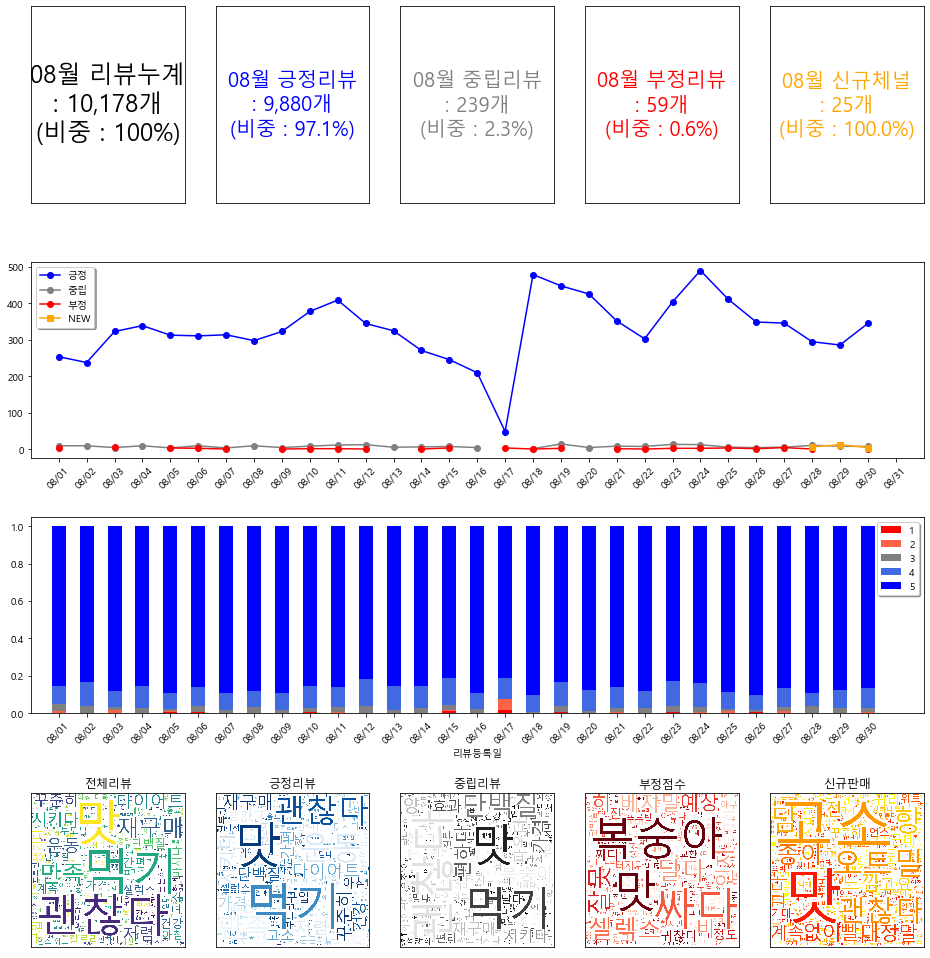

In [26]:
# 그래프 생성
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_cs_Trend_graph.png'

fig = plt.figure(figsize=(16, 30))

###############
# 당월 리뷰내용 요약
#####
ax1 = plt.subplot2grid((7, 5), (0, 0))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =24, 
         s='{}월 리뷰누계\n: {:,.0f}개\n(비중 : {:,.0f}%)'.format(datetime.now().strftime('%m'), len(df_review_all),len(df_review_all)/len(df_review_all)*100 ) )

ax2 = plt.subplot2grid((7, 5), (0, 1))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'blue', 
         s='{}월 긍정리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_pos),len(df_review_pos)/len(df_review_all)*100 ) )

ax3 = plt.subplot2grid((7, 5), (0, 2))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'gray',
         s='{}월 중립리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_nue),len(df_review_nue)/len(df_review_all)*100 ) )

ax4 = plt.subplot2grid((7, 5), (0, 3))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'red',
         s='{}월 부정리뷰\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_neg),len(df_review_neg)/len(df_review_all)*100 ) )

ax5 = plt.subplot2grid((7, 5), (0, 4))
plt.xticks([]); plt.yticks([])
plt.axis([0, 2, 0, 2])
plt.text(1, 1, ha = 'center', va = 'center', fontsize =20, c = 'orange',
         s='{}월 신규채널\n: {:,.0f}개\n(비중 : {:,.1f}%)'.format(datetime.now().strftime('%m'), len(df_review_all2),len(df_review_all2)/len(df_review_all2)*100 ) )


###############
# 일별 리뷰내용 추이
#####
ax6 = plt.subplot2grid((7, 5), (1, 0), colspan=5)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.plot(REPORT_01.리뷰등록일, REPORT_01.긍정리뷰, marker="o", color= 'blue', label='긍정')
plt.plot(REPORT_01.리뷰등록일, REPORT_01.중립리뷰, marker="o", color= 'gray', label='중립')
plt.plot(REPORT_01.리뷰등록일, REPORT_01.부정리뷰, marker="o", color= 'red',  label='부정')
plt.plot(REPORT_01.리뷰등록일, REPORT_01.신규체널, marker="s", color= 'orange',  label='NEW')
lgd = plt.legend(loc='best',fancybox=True, shadow=True)
plt.xticks(rotation=45)
plt.xlim(-1,31)



###############
# 일별 리뷰내용 비율
#####
ax7 = plt.subplot2grid((7, 5), (2, 0), colspan=5)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
colors = ['red', 'tomato', 'gray', 'royalblue', 'blue' ]
pd.crosstab(df_review_all.리뷰등록일, df_review_all.구매자평점, normalize='index').plot.bar(stacked=True,  ax = ax7, color=colors)
lgd = plt.legend(loc='best',fancybox=True, shadow=True)
plt.xlim(-1,31)
plt.xticks(rotation=45)


###############
# word cloud
#####

ax8 = plt.subplot2grid((7, 5), (3, 0))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all['token'], None), cmap=plt.cm.binary)
plt.title('전체리뷰',fontsize='large')

ax9 = plt.subplot2grid((7, 5), (3, 1))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_pos['token'], 'Blues_r'), cmap=plt.cm.binary)
plt.title('긍정리뷰',fontsize='large')

ax10 = plt.subplot2grid((7, 5), (3, 2))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_nue['token'], 'gray'), cmap=plt.cm.binary)
plt.title('중립리뷰',fontsize='large')

ax11 = plt.subplot2grid((7, 5), (3, 3))
plt.xticks([]); plt.yticks([]); plt.grid(False)
try:
    plt.imshow(wordcloud_gen(df_review_neg['token'], 'Reds'), cmap=plt.cm.binary)
except:
    pass
plt.title('부정점수',fontsize='large')

ax12 = plt.subplot2grid((7, 5), (3, 4))
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all2['token'], 'autumn'), cmap=plt.cm.binary)
plt.title('신규채널',fontsize='large')

plt.show()

# plt.savefig(image_name, bbox_inches='tight', dpi=70)


In [105]:
df_review_all2

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token,token_attribution
132,4,셀렉스 썬화이버 프리바이오틱스 125g (12.5g x 10개입),08/26,카카오메이커스,프로바이오틱스,셀렉스 면역 프로바이오틱스 캡슐,"[셀렉스/Noun, 써다/Verb, 화이/Noun, 버/Noun, 프리바이오틱스/N..."
133,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,07/30,카카오메이커스,프로바이오틱스,셀렉스 면역 프로바이오틱스 캡슐,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."
134,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,08/01,카카오메이커스,프로바이오틱스,셀렉스 면역 프로바이오틱스 캡슐,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."
135,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,07/31,카카오메이커스,프로바이오틱스,셀렉스 면역 프로바이오틱스 캡슐,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."
136,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,08/11,카카오메이커스,프로바이오틱스,셀렉스 면역 프로바이오틱스 캡슐,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."
...,...,...,...,...,...,...,...
279,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,07/31,카카오메이커스,프로바이오틱스,NaN,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."
280,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,07/31,카카오메이커스,프로바이오틱스,NaN,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."
281,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,07/31,카카오메이커스,프로바이오틱스,NaN,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."
282,4,셀렉스 면역 프로바이오틱스 330mg x 30캡슐,07/31,카카오메이커스,프로바이오틱스,NaN,"[셀렉스/Noun, 면역/Noun, 프로바이오틱스/Noun, 330/Number, ..."


In [117]:
df_review_gitar.head()

,문의내용,문의상세내용,문의등록일,수집채널,category2,token,token_attribution
0,기타,"제로샵 상담사02-550-8201로부터 전달받음. 출고전 취소 승인 했는데, 출고되...",08/05,9 엠써클(제로샵),아몬드브리즈,제로 샵 상담사 로부터 전달 받다 출고 전 취소 승인 하다 출고 되어다 회...,"[제로/Noun, 샵/Noun, 상담사/Noun, 02-550/Number, -/P..."
1,기타,2021070352713801 \n\n리뷰 글번호 3234808724|관련리뷰 (일...,08/06,3 네이버,아몬드브리즈,리뷰 글 번호 관련 리뷰 일반 상품 주문 번호 상품 명 ...,"[2021070352713801/Number, 리뷰/Noun, 글/Noun, 번호/..."
2,기타,리뷰 글번호 3234527139|관련리뷰 (일반 3211200192) ...,08/06,3 네이버,아몬드브리즈,리뷰 글 번호 관련 리뷰 일반 상품 주문 번호 상품 명 ...,"[리뷰/Noun, 글/Noun, 번호/Noun, 3234527139/Number, ..."
3,기타,K쇼핑상담사 ㅁ회수송장:842733153835\n\n8/7 업체입고 확인됩니다\n...,08/09,33 K쇼핑,아몬드브리즈,쇼핑 상담사 ㅁ 회수 송장 업체 입다 확인 되다 업체 입 고여 부와 배송비 ...,"[K/Alpha, 쇼핑/Noun, 상담사/Noun, ㅁ/KoreanParticle,..."
4,기타,Y2108045663694\n[업체배송] 아몬드브리즈 언스위트 190ml 24팩/언...,08/10,34 올리브영,아몬드브리즈,업체 배송 아몬드 브리 즈 언스위트 팩 언스위트 팩 세트 주...,"[Y/Alpha, 2108045663694/Number, [/Punctuation,..."


In [559]:
###############
# 리포트용 자료 만들기 : 5.키워드별 rawdata
#####

data_by_keyword = pd.DataFrame()

category_count = []
for text1 ,text2 in category :
    df_sort = df_review_all[(df_review_all['token'].str.contains(str(text2)))]
    df_sort = df_sort[(df_sort['category2'].str.contains(str(text1)))][['리뷰등록일','수집채널','리뷰상세내용','구매자평점', 'category2']]
    df_sort = df_sort.drop_duplicates()
    if len(df_sort) > 0:
        df_sort['키워드'] = text2
        category_count.append(len(df_sort))
        data_by_keyword = pd.concat([df_sort, data_by_keyword]) 
    else:
        category_count.append(int(0))
        
report_05 = pd.DataFrame(category)
report_05 = report_05.rename(columns={0: "Category", 1: "키워드"})
report_05['리뷰개수'] = category_count

In [560]:
report_05

,Category,키워드,리뷰개수
0,아몬드브리즈,비리다,3
1,아몬드브리즈,냄새,1
2,아몬드브리즈,맛없다,12
3,아몬드브리즈,밍밍,50
4,두유,비리다,19
5,두유,냄새,2
6,두유,맛없다,13
7,두유,밍밍,37
8,두유,달다,80


In [561]:
data_by_keyword

,리뷰등록일,수집채널,리뷰상세내용,구매자평점,category2,키워드
482,2021-07-22,3 네이버,"자주 먹던건데, 단백질 두유보단 더 달아요",5,두유,달다
485,2021-07-22,3 네이버,다른 제품은 너무 달아서 바꿔봤는데 많이 달지 않고 건강하게 꾸준히 먹을 수 있을 ...,5,두유,달다
512,2021-07-22,3 네이버,맛있어요~ \n완전 달진 않으나 고소한 맛이 👍,5,두유,달다
657,2021-07-22,3 네이버,많이 비리지 않고 적당히 달아서 괜찮았어요!,5,두유,달다
662,2021-07-22,3 네이버,처음먹어보는 고단백 두유인데 생각보다 늦게 하지 않고 적당히 달아요,5,두유,달다
...,...,...,...,...,...,...
7992,2021-08-04,3 네이버,맛있어요 누가맛없다했는데 두유맛임,5,아몬드브리즈,맛없다
1192,2021-07-23,3 네이버,사은품과 같이 배송되었어요\n드라이백만 구입하려해도 몇만원하는데^^\n품질도 좋고 ...,5,아몬드브리즈,냄새
578,2021-07-22,3 네이버,두유에서 비린맛 나서 싫으신분들이면 좋아할꺼같아요 ㅎㅎ 묵직한 느낌은 없고 가벼운느...,5,아몬드브리즈,비리다
5496,2021-07-30,3 네이버,비린내 없고 깔끔한 맛이 너무 좋아요!!,5,아몬드브리즈,비리다


In [56]:
# df_review_neg.head()

In [59]:
remove_word = ['빠르다', '도착', '배송']
pattern = '|'.join(remove_word)
REPORT_02 = df_review_nue.loc[ ~df_review_nue['token'].str.contains(pattern, case=False) ].head(10)

In [60]:
REPORT_02

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token,token_attribution
69,3,항상 먹는 두유376시,2021-08-10,3 네이버,두유,항상 먹다 두유 시,"[항상/Noun, 먹다/Verb, 두유/Noun, 376시/Number]"
78,3,입맛에 안맞았어요 ㅠㅠㅠ,2021-08-10,3 네이버,두유,입맛 에 안 맞다 어요 ㅠㅠㅠ,"[입맛/Noun, 에/Josa, 안/VerbPrefix, 맞다/Verb, 어요/No..."
153,3,세번째 구매입니다. 맛있어요,2021-08-10,3 네이버,두유,세번 째다 구 매입 니 다 맛있다 어요,"[세번/Noun, 째다/Verb, 구/Noun, 매입/Noun, 니/Josa, 다/..."
164,3,저렴하게 잘샀어요. 많이 달지 않고 단백하고 고소해요,2021-08-10,3 네이버,두유,저렴 하다 잘 사다 어요 많이 달 지 않다 단백 하고 고소 해 요,"[저렴/Noun, 하다/Verb, 잘/VerbPrefix, 사다/Verb, 어요/N..."
203,3,맛있어요\n게다가 건강한 맛,2021-08-10,3 네이버,두유,맛있다 어요 게다가 건강 한 맛,"[맛있다/Adjective, 어요/Noun, 게다가/Noun, 건강/Noun, 한/..."
234,3,단맛이 생각보다는 적습니다. 단백하고 맛있어요,2021-08-10,3 네이버,두유,단맛 이 생각 보다는 적다 단백 하고 맛있다 어요,"[단맛/Noun, 이/Josa, 생각/Noun, 보다는/Josa, 적다/Verb, ..."
252,3,골고루 먹고 있는데 고단백은 첨인데 아들 운동후 괜찮을것 같네요,2021-08-10,3 네이버,두유,골 고루 먹다 있다 고 단백 은 첨 인데 아들 운동 후 괜찮다 같다,"[골/Noun, 고루/Noun, 먹다/Verb, 있다/Adjective, 고/Nou..."
374,3,가성비 대비 괜찮았고 달지 않네요.,2021-08-09,3 네이버,두유,가성 비 대비 괜찮다 달 지 않다,"[가성/Noun, 비/Noun, 대비/Noun, 괜찮다/Adjective, 달/No..."
375,3,떨어지지 않게 시켜먹습니다,2021-08-09,3 네이버,두유,떨다 지지 않다 시키다 먹다,"[떨다/Verb, 지지/Noun, 않다/Verb, 시키다/Verb, 먹다/Verb]"
457,3,너무 싱거워요 물탄듯한 맛이에요! 아쉽네요!,2021-08-09,3 네이버,두유,너무 싱겁다 물탄 듯 한 맛 이에요 아쉽다,"[너무/Adverb, 싱겁다/Adjective, 물탄/Noun, 듯/Noun, 한/..."


In [562]:
##########
# Excel 파일 생성(using XlsxWriter)
###

date2 = datetime.today().strftime('%Y%m%d')
date2 = date2[2:]
excel_name = date2 + '_report.xlsx'
writer = pd.ExcelWriter(excel_name, engine='xlsxwriter')

# 1.키워드별 리뷰내용
data_by_keyword.to_excel(writer, sheet_name='1.키워드기준 리뷰')

# 2.부정리뷰
df_review_neg.to_excel(writer, sheet_name='2.부정리뷰)')

writer.save()

In [654]:
writer.close()